In [12]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.cluster import KMeans

In [6]:
# Load image
img = imread('/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD589_lossless_aligned_cropped_grayscale/MD589_0134_lossless_aligned_cropped_grayscale.tif');

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


In [15]:
print "image shape %s" %(img.shape,);

image shape (17632, 16704)


In [17]:
landmap = np.load("/oasis/projects/nsf/csd395/yuncong/CSHL_data_patches/dense_labelmap2/labelmap_134.npy");
print "landmap shape %s" %(landmap.shape,); # image should be trimmed to fit landmap

landmap shape (17632, 16704)


In [24]:
# slice the part that belong to class 1
indices = np.where(landmap == 1);
x_min = indices[0][0];
x_max = indices[0][-1];
y_min = indices[1][0];
y_max = indices[1][-1];
print "x_min:{0}, x_max:{1}, y_min:{2}, y_max:{3})".format(x_min, x_max, y_min, y_max);
im = img[x_min:x_max, y_min:y_max];

x_min:8859, x_max:11034, y_min:1169, y_max:1925)


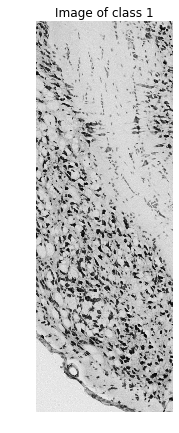

In [25]:
plt.figure(figsize=((x_max-x_min)/100,(y_max-y_min)/100));
plt.imshow(im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('Image of class 1');

In [57]:
L = 3;  # Total number of levels
M = 200;

# Function of computing the vocabulary histogram in one grid
def computeGridVocabulary(sample, size):
    sift = cv2.SIFT();
    key_point, descriptor = sift.detectAndCompute(sample, None);
    kmeans = KMeans(init='random', n_clusters=size, n_init=10);
    kmeans.fit(descriptor);
    return kmeans.cluster_centers_;

# Function of extracting the vocabulary histogram from an image ndarray
def computeWholeVocabulary(picture, level, size):
    # Level 0
    weight_0 = 0.25;
    x_size = x_max - x_min;
    y_size = y_max - y_min;
    voc_0 = computeVocabulary(picture, size) * weight_0;
    # Level 1 to L-1
    for l in range(1, level):
        weight = 1.0/(2**(level - l + 1));
        x_size = (x_max - x_min) / (2**l);
        y_size = (y_max - y_min) / (2**l);
        for i in range(0, (2**l)):
            for j in range(0, (2**l)):
                current_img = picture[i*x_size:i*x_size + x_size, j*y_size:j*y_size + y_size];
                voc = computeVocabulary(current_img, size) * weight;
                voc_0 = np.vstack((voc_0, voc));
    return voc_0;

In [58]:
vocabulary = computeWholeVocabulary(im, L, M);

In [59]:
print "Vocabulary shape: %s" %(vocabulary.shape,);

Vocabulary shape: (4200, 128)
